### Visualize sample methylation matrix with PCA

This notebook is for visualizing methylation matrices and their deconvolution results

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

!conda info | grep 'active env'

In [3]:
data = pd.read_csv('../output/blueprint_meth_summaries_cg_count_geq_3_deconvolution_v2.v23_conv.with_cpg_index.tsv.gz',sep='\t')
sample_df = pd.read_csv('../stage/metadata/samples_wgbs.20230329.tsv',sep='\t')
metadata = sample_df[['sample_id','sample_group', 'age']] \
    .rename({'sample_id':'SAMPLE_ID'},axis=1) \
    .drop_duplicates()

In [81]:
A = data.sample_id.unique()
B = list(sample_df.sample_id)

print(len(A))
print(len(B))

127
414


In [85]:
def difference(listA, listB):
    return set(listA).difference(set(listB))

# 23 samples in data not in sample_df
print(len(difference(A, B)))

23


### Run PCA on reference regions

In [5]:
# Run PCA
X =  data[['sample_id','region_id','frac_alpha_leq_25pct']] \
    .pivot_table(index='region_id',columns=['sample_id'],values='frac_alpha_leq_25pct') \
    .transpose() 

samples = X.index.values
X = X.to_numpy()
X[np.isnan(X)] = 0

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
pca = PCA(n_components=5)
result = pca.fit(X)
pca_df = pd.DataFrame(result.transform(X))

In [10]:
pca_df = pca_df \
    .rename({0:'PC1',1:'PC2',2:'PC3',3:'PC4',4:'PC5'},axis=1) \
     .assign(SAMPLE_ID=samples) \
     .merge(metadata, how='inner')

In [38]:
pca_df.shape

(104, 6)

### PCs colored by cell type

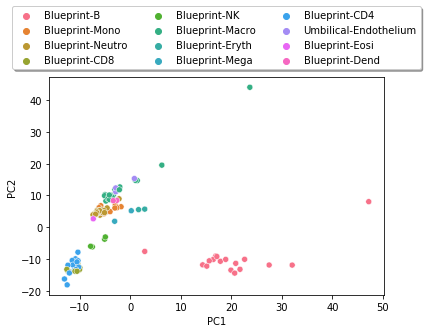

In [11]:
sns.scatterplot(x="PC1",y="PC2",hue="sample_group",data=pca_df)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=3, fancybox=True, shadow=True)

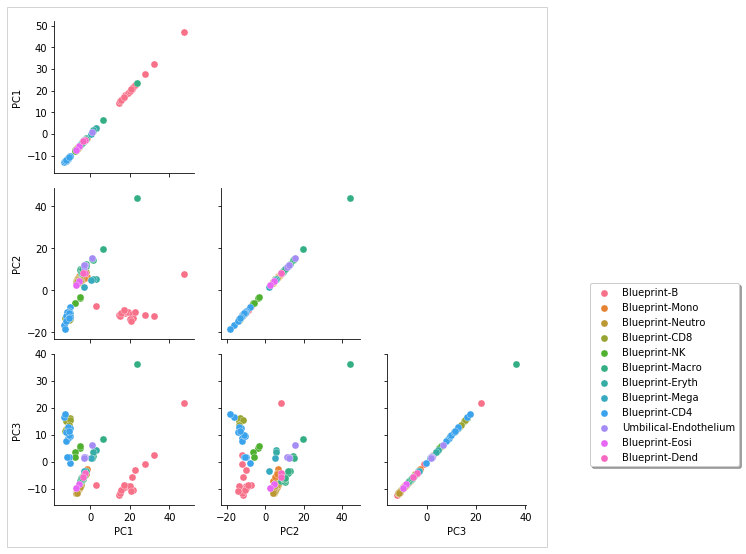

In [140]:
g = sns.PairGrid(pca_df, hue='sample_group')
g.map(plt.scatter, s=50, edgecolor='white', linewidth=.3)

# Remove axes of the upper triangle
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

    
# g.map_diag(sns.histplot)  
plt.legend(loc='upper center', bbox_to_anchor=(2, 1.5), ncol=1, fancybox=True, shadow=True)
# plt.title("Pairwise PC plots colored by AGE")

# Draw a box around all plots
g.fig.patches.extend([plt.Rectangle((0,0),1,1, fill=False, color='lightgrey', 
                                     transform=g.fig.transFigure, figure=g.fig)])

plt.show()

In [148]:
data.region_id

0                  Immune_Broad_Neutro-chr1:9147789-9147871
1                  Immune_Broad_Neutro-chr1:9147789-9147871
2                  Immune_Broad_Neutro-chr1:9147789-9147871
3                  Immune_Broad_Neutro-chr1:9147789-9147871
4                  Immune_Broad_Neutro-chr1:9147789-9147871
                                ...                        
206298    Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...
206299    Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...
206300    Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...
206301    Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...
206302    Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...
Name: region_id, Length: 206303, dtype: object

### PCs colored by age

In [33]:
# all age range
metadata.age.unique()

array(['53.0', '35.0', '37.0', '33.0', '62.0', '54.0', '52.0', '34.0',
       '67.0', '60.0', '47.0', '65.0', '74.0', '46.0', '28.0', '76.0',
       '81.0', '61.0', '49.0', '55.0', '50.0', '73.0', '59.0', '22.0',
       '17.0', '51.0', '26.0', '57.0', '83.0', '71.0', '70.0', '5.0',
       '31.0', '56.0', '25.0', '39.0', '38.0', '19.0', '24.0', nan,
       '66.0', '45.0', '23.0', '58.0', '43.0', '40.0', '36.0', '72.0',
       '29.0', '42.0', '64.0', '30.0', '69.0', '79.0', '32.0', '27.0',
       '20.0', '3.0', '75.0', '41.0', '68.0', '44.0', '78.0', '48.0',
       '63.0', '0 - 5', '65 - 70', '80 - 85', '70 - 75', '20 - 30',
       '40 - 45', '35 - 40', '50 - 55', '60 - 65', '55 - 60', '20 - 40',
       '45 - 50', '30 - 35', '25 - 30', '37', '66', '74', '68', '55',
       '75', '25', '72', '69', '58', '39', '53', '49', '73', '63', '62',
       '60', '42', '48', '21'], dtype=object)

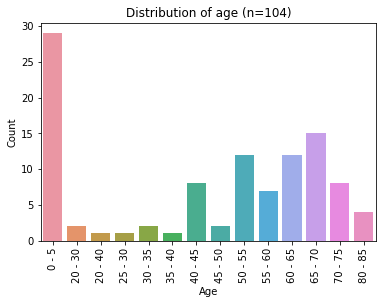

In [93]:
# barplot of age
counts = pca_df.age.value_counts()
age_order = ['0 - 5', '20 - 30', '20 - 40', '25 - 30', 
             '30 - 35', '35 - 40', '40 - 45', '45 - 50', 
             '50 - 55', '55 - 60', '60 - 65', '65 - 70', 
             '70 - 75', '80 - 85']
counts = counts.loc[age_order]

sns.barplot(x=counts.index, y=counts.values)

plt.title('Distribution of age (n=104)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

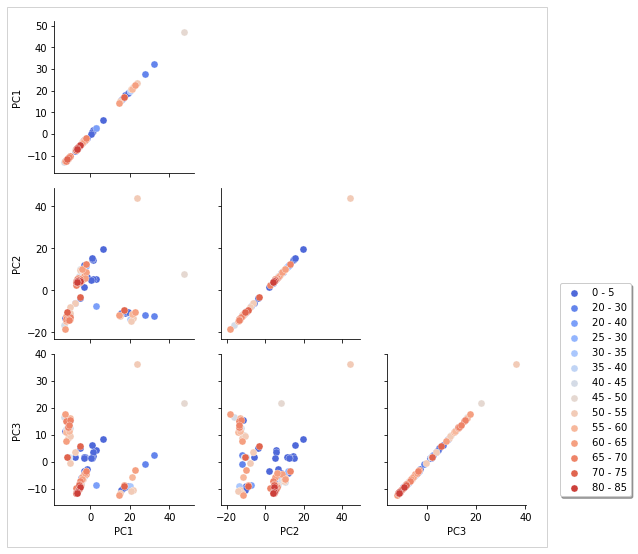

In [142]:
g = sns.PairGrid(pca_df, hue='age', palette='coolwarm', hue_order=age_order)
g.map(plt.scatter, s=50, edgecolor='white', linewidth=.3)

# Remove axes of the upper triangle
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

    
# g.map_diag(sns.histplot)  
plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1.5), ncol=1, fancybox=True, shadow=True)
# plt.title("Pairwise PC plots colored by AGE")

# Draw a box around all plots
g.fig.patches.extend([plt.Rectangle((0,0),1,1, fill=False, color='lightgrey', 
                                     transform=g.fig.transFigure, figure=g.fig)])

plt.show()

### PCs colored by sex

### Reference region hypo-methylation distribution

In [146]:
data.region_id

0                  Immune_Broad_Neutro-chr1:9147789-9147871
1                  Immune_Broad_Neutro-chr1:9147789-9147871
2                  Immune_Broad_Neutro-chr1:9147789-9147871
3                  Immune_Broad_Neutro-chr1:9147789-9147871
4                  Immune_Broad_Neutro-chr1:9147789-9147871
                                ...                        
206298    Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...
206299    Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...
206300    Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...
206301    Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...
206302    Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...
Name: region_id, Length: 206303, dtype: object